In [1]:
from datasets import SinusoidDataset
from models import MLPCNF
from lightning import Trainer
from lightning.pytorch.callbacks import RichModelSummary

In [2]:
dataset = SinusoidDataset(
    sample_rate=1.0,
    observation_time=16,
    noise_cov=0.1,
)
model = MLPCNF(
    dim=3,
    obs_dim=len(dataset.observation_times),
    hidden_dim=128,
    depth=4,
    lr=1e-4,
)
# model = torch.compile(model)

train_dataloader = dataset.dataloader(
    batch_size=1024,
    batches=1024,
    num_workers=32,
    persistent_workers=True,
    # pin_memory=True,
)
trainer = Trainer(
    accelerator="cpu",
    #devices="2,",
    max_epochs=10,
    callbacks=[RichModelSummary()],
)
trainer.fit(model, train_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


┏━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩
│ 0 │ flow │ MLP  │ 53.4 K │
└───┴──────┴──────┴────────┘

Trainable params: 53.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 53.4 K                                                                                               
Total estimated model params size (MB): 0

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/3 [00:00<?, ?it/s]

Pushing data through flow


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Running MCMC sampling


100%|██████████| 300/300 [00:05<00:00, 56.84it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:12<00:00, 39.45it/s]


Pushing data through flow


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


Running MCMC sampling


100%|██████████| 300/300 [00:09<00:00, 32.74it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:21<00:00, 24.06it/s]


Pushing data through flow


100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Running MCMC sampling


100%|██████████| 300/300 [00:16<00:00, 18.12it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 512/512 [00:15<00:00, 34.06it/s]


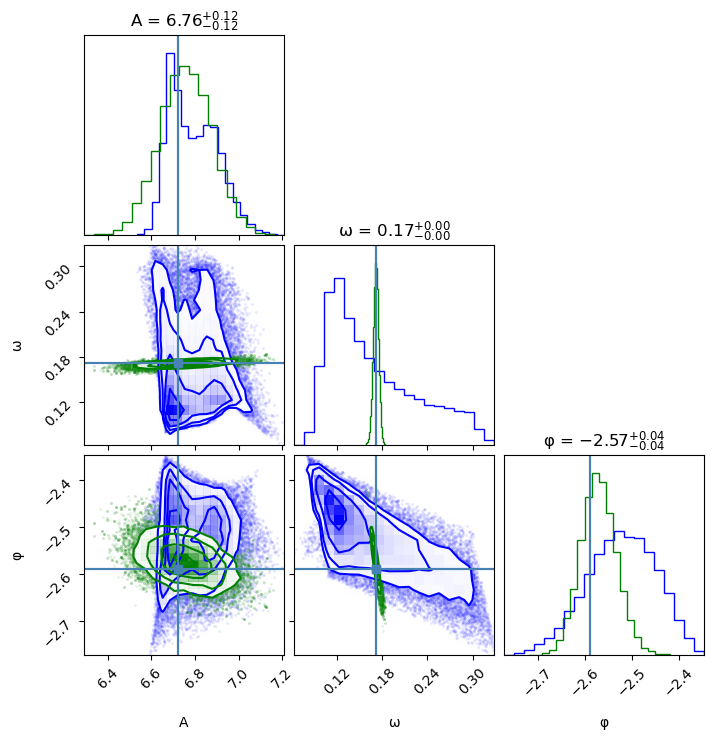

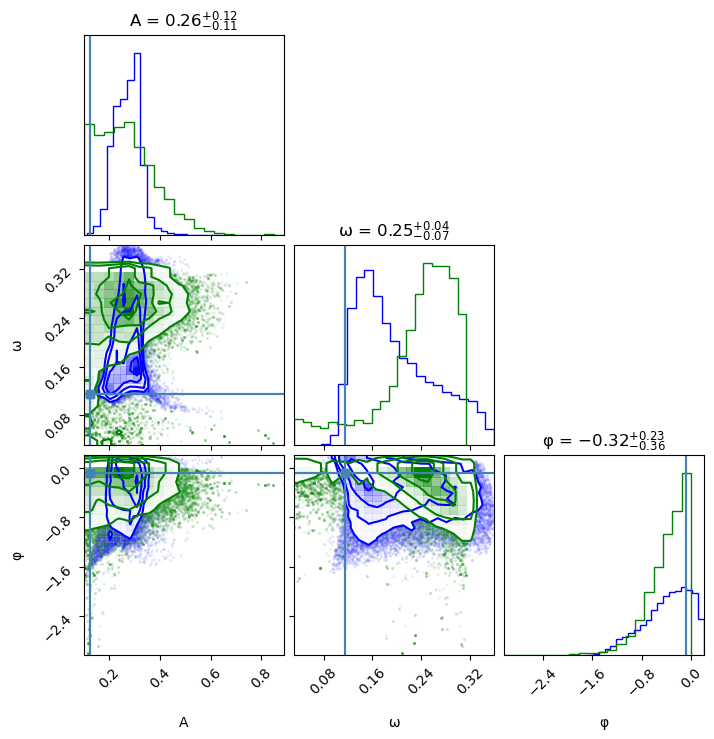

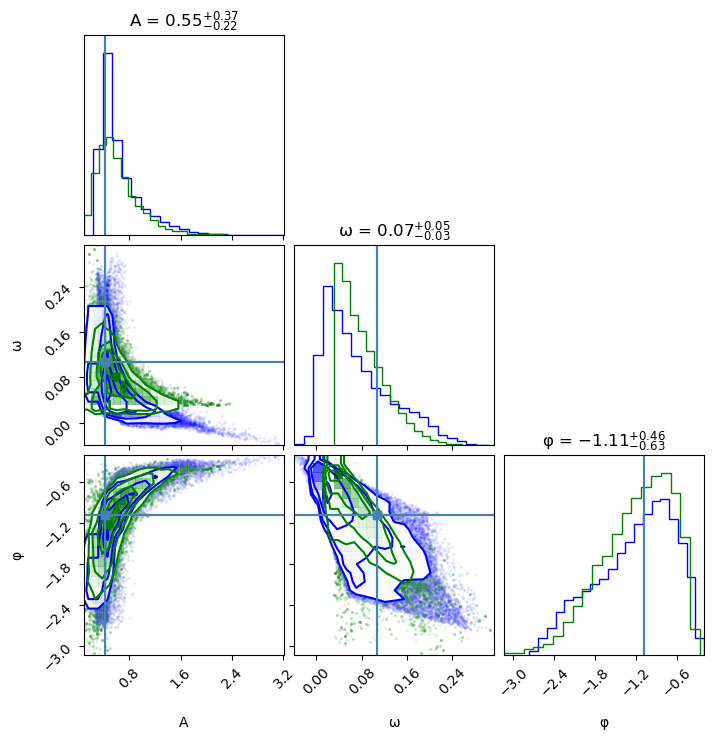

In [3]:
from utils import corner_plot
corner_plot(dataset, model, examples=3, ode_steps=16, samples=32*1024, verbose=True)